## GrahpCast Model For SL Weather Forcasting

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.loader import DataLoader  # Fixed deprecation warning here
import numpy as np
import xarray as xr
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional
import warnings
import os

# ----- Graph Conv Layer -----

In [2]:
class GraphConvLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, edge_dim=1, aggr='mean'):
        super().__init__(aggr=aggr)
        self.mlp = nn.Sequential(
            nn.Linear(2 * in_channels + edge_dim, 128),
            nn.ReLU(),
            nn.Linear(128, out_channels)
        )
    def forward(self, x, edge_index, edge_attr):
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_i, x_j, edge_attr):
        return self.mlp(torch.cat([x_i, x_j, edge_attr], dim=-1))

# ----- GraphCast Model -----

In [3]:
# ----- GraphCast Model -----
class GraphCast(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=None, num_layers=4, edge_dim=1):
        super().__init__()
        if output_dim is None:
            output_dim = input_dim
        self.input_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv_layers = nn.ModuleList([
            GraphConvLayer(hidden_dim, hidden_dim, edge_dim=edge_dim)
            for _ in range(num_layers)
        ])
        self.layer_norms = nn.ModuleList([
            nn.LayerNorm(hidden_dim) for _ in range(num_layers)
        ])
        self.output_decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.use_residual = True

    def forward(self, x, edge_index, edge_attr):
        x = self.input_encoder(x)
        for conv, norm in zip(self.conv_layers, self.layer_norms):
            residual = x
            x = conv(x, edge_index, edge_attr)
            x = norm(x)
            if self.use_residual and x.shape == residual.shape:
                x = x + residual
            x = F.relu(x)
        x = self.output_decoder(x)
        return x

### ----- Weather Forecasting Evaluation Metrics -----

In [4]:
# ----- Weather Forecasting Evaluation Metrics -----
class WeatherForecastMetrics:
    """Comprehensive evaluation metrics for weather forecasting models."""

    def __init__(self, variable_names: List[str], scalers: Optional[Dict] = None):
        self.variable_names = variable_names
        self.scalers = scalers

    def rmse(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """Root Mean Square Error"""
        return np.sqrt(mean_squared_error(y_true, y_pred))

    def mae(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """Mean Absolute Error"""
        return mean_absolute_error(y_true, y_pred)

    def mape(self, y_true: np.ndarray, y_pred: np.ndarray, epsilon=1e-8) -> float:
        """Mean Absolute Percentage Error"""
        return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

    def bias(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """Mean Bias (systematic error)"""
        return np.mean(y_pred - y_true)

    def correlation(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """Pearson correlation coefficient"""
        return np.corrcoef(y_true.flatten(), y_pred.flatten())[0, 1]

    def anomaly_correlation(self, y_true: np.ndarray, y_pred: np.ndarray, climatology: np.ndarray) -> float:
        """Anomaly Correlation Coefficient (ACC) - key metric for weather forecasting"""
        true_anomaly = y_true - climatology
        pred_anomaly = y_pred - climatology

        numerator = np.sum(true_anomaly * pred_anomaly)
        denominator = np.sqrt(np.sum(true_anomaly ** 2) * np.sum(pred_anomaly ** 2))

        return numerator / (denominator + 1e-8)

    def skill_score(self, y_true: np.ndarray, y_pred: np.ndarray, reference_pred: np.ndarray) -> float:
        """Skill Score compared to reference forecast (e.g., persistence or climatology)"""
        mse_model = mean_squared_error(y_true, y_pred)
        mse_reference = mean_squared_error(y_true, reference_pred)

        return 1 - (mse_model / (mse_reference + 1e-8))

    def hit_rate(self, y_true: np.ndarray, y_pred: np.ndarray, threshold: float, above: bool = True) -> float:
        """Hit Rate for threshold exceedance events"""
        if above:
            true_events = y_true >= threshold
            pred_events = y_pred >= threshold
        else:
            true_events = y_true <= threshold
            pred_events = y_pred <= threshold

        hits = np.sum(true_events & pred_events)
        total_events = np.sum(true_events)

        return hits / (total_events + 1e-8)

    def false_alarm_rate(self, y_true: np.ndarray, y_pred: np.ndarray, threshold: float, above: bool = True) -> float:
        """False Alarm Rate for threshold exceedance events"""
        if above:
            true_events = y_true >= threshold
            pred_events = y_pred >= threshold
        else:
            true_events = y_true <= threshold
            pred_events = y_pred <= threshold

        false_alarms = np.sum(~true_events & pred_events)
        total_non_events = np.sum(~true_events)

        return false_alarms / (total_non_events + 1e-8)

    def critical_success_index(self, y_true: np.ndarray, y_pred: np.ndarray, threshold: float,
                               above: bool = True) -> float:
        """Critical Success Index (CSI) - useful for precipitation forecasting"""
        if above:
            true_events = y_true >= threshold
            pred_events = y_pred >= threshold
        else:
            true_events = y_true <= threshold
            pred_events = y_pred <= threshold

        hits = np.sum(true_events & pred_events)
        misses = np.sum(true_events & ~pred_events)
        false_alarms = np.sum(~true_events & pred_events)

        return hits / (hits + misses + false_alarms + 1e-8)

    def compute_climatology(self, data: np.ndarray, time_axis: int = 0) -> np.ndarray:
        """Compute climatological mean for anomaly calculations"""
        return np.mean(data, axis=time_axis, keepdims=True)

    def persistence_forecast(self, data: np.ndarray, lead_time: int = 1) -> np.ndarray:
        """Generate persistence forecast (last observation carried forward)"""
        return np.roll(data, lead_time, axis=0)

    def evaluate_variable(self, y_true: np.ndarray, y_pred: np.ndarray,
                          variable_name: str, climatology: Optional[np.ndarray] = None,
                          persistence: Optional[np.ndarray] = None) -> Dict[str, float]:
        """Comprehensive evaluation for a single variable"""

        # Denormalize if scalers are available
        if self.scalers and variable_name in self.scalers:
            scaler = self.scalers[variable_name]
            y_true_orig = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
            y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
            if climatology is not None:
                climatology_orig = scaler.inverse_transform(climatology.reshape(-1, 1)).flatten()
            if persistence is not None:
                persistence_orig = scaler.inverse_transform(persistence.reshape(-1, 1)).flatten()
        else:
            y_true_orig = y_true
            y_pred_orig = y_pred
            climatology_orig = climatology
            persistence_orig = persistence

        metrics = {
            'rmse': self.rmse(y_true_orig, y_pred_orig),
            'mae': self.mae(y_true_orig, y_pred_orig),
            'mape': self.mape(y_true_orig, y_pred_orig),
            'bias': self.bias(y_true_orig, y_pred_orig),
            'correlation': self.correlation(y_true_orig, y_pred_orig),
            'r2_score': r2_score(y_true_orig, y_pred_orig)
        }

        # Anomaly correlation if climatology is provided
        if climatology_orig is not None:
            metrics['anomaly_correlation'] = self.anomaly_correlation(
                y_true_orig, y_pred_orig, climatology_orig
            )

        # Skill scores if persistence is provided
        if persistence_orig is not None:
            metrics['skill_score_vs_persistence'] = self.skill_score(
                y_true_orig, y_pred_orig, persistence_orig
            )

        # Variable-specific thresholds and metrics
        if variable_name in ['tp', 'precipitation']:  # Precipitation
            thresholds = [0.1, 1.0, 5.0, 10.0]  # mm
            for threshold in thresholds:
                metrics[f'hit_rate_{threshold}mm'] = self.hit_rate(y_true_orig, y_pred_orig, threshold, above=True)
                metrics[f'false_alarm_rate_{threshold}mm'] = self.false_alarm_rate(y_true_orig, y_pred_orig, threshold,
                                                                                   above=True)
                metrics[f'csi_{threshold}mm'] = self.critical_success_index(y_true_orig, y_pred_orig, threshold,
                                                                            above=True)

        elif variable_name in ['t2m', 'temperature']:  # Temperature
            # Extreme temperature thresholds (you may need to adjust based on your region)
            cold_threshold = 273.15  # 0°C in Kelvin
            hot_threshold = 303.15  # 30°C in Kelvin
            metrics['hit_rate_freezing'] = self.hit_rate(y_true_orig, y_pred_orig, cold_threshold, above=False)
            metrics['hit_rate_hot'] = self.hit_rate(y_true_orig, y_pred_orig, hot_threshold, above=True)

        elif variable_name in ['u10', 'v10', 'wind']:  # Wind speed
            wind_speed_true = np.sqrt(y_true_orig ** 2) if variable_name == 'u10' else np.abs(y_true_orig)
            wind_speed_pred = np.sqrt(y_pred_orig ** 2) if variable_name == 'u10' else np.abs(y_pred_orig)
            strong_wind_threshold = 10.0  # m/s
            metrics['hit_rate_strong_wind'] = self.hit_rate(wind_speed_true, wind_speed_pred, strong_wind_threshold,above=True)

        return metrics

    def evaluate_all_variables(self, y_true: np.ndarray, y_pred: np.ndarray,
                               climatology: Optional[np.ndarray] = None,
                               persistence: Optional[np.ndarray] = None) -> Dict[str, Dict[str, float]]:
        """Evaluate all variables and return comprehensive metrics"""

        results = {}
        n_variables = y_true.shape[-1]

        for i, var_name in enumerate(self.variable_names[:n_variables]):
            var_true = y_true[..., i]
            var_pred = y_pred[..., i]
            var_climatology = climatology[..., i] if climatology is not None else None
            var_persistence = persistence[..., i] if persistence is not None else None

            results[var_name] = self.evaluate_variable(
                var_true, var_pred, var_name, var_climatology, var_persistence
            )

        return results

    def print_summary(self, results: Dict[str, Dict[str, float]]):
        """Print a formatted summary of evaluation results"""
        print("\n" + "=" * 80)
        print("WEATHER FORECASTING EVALUATION SUMMARY")
        print("=" * 80)

        for var_name, metrics in results.items():
            print(f"\n{var_name.upper()}:")
            print("-" * 40)

            # Core metrics
            print(f"  RMSE:              {metrics['rmse']:.4f}")
            print(f"  MAE:               {metrics['mae']:.4f}")
            print(f"  MAPE:              {metrics['mape']:.2f}%")
            print(f"  Bias:              {metrics['bias']:.4f}")
            print(f"  Correlation:       {metrics['correlation']:.4f}")
            print(f"  R² Score:          {metrics['r2_score']:.4f}")

            if 'anomaly_correlation' in metrics:
                print(f"  Anomaly Corr:      {metrics['anomaly_correlation']:.4f}")

            if 'skill_score_vs_persistence' in metrics:
                print(f"  Skill Score:       {metrics['skill_score_vs_persistence']:.4f}")

            # Variable-specific metrics
            threshold_metrics = {k: v for k, v in metrics.items() if
                                 any(x in k for x in ['hit_rate', 'false_alarm', 'csi'])}
            if threshold_metrics:
                print("  Threshold Metrics:")
                for metric_name, value in threshold_metrics.items():
                    print(f"    {metric_name}: {value:.4f}")

#### ----- ERA5 Preprocessing -----

In [5]:
# ----- ERA5 Preprocessing -----
class ERA5Preprocessor:
    def __init__(self, normalize=True):
        self.normalize = normalize
        self.scalers = {}

    def load_era5_data(self, file_path: str) -> xr.Dataset:
        return xr.open_dataset(file_path)

    def preprocess_dataset(self, ds: xr.Dataset, variables=None):
        if variables is None:
            variables = list(ds.data_vars.keys())
        # Flexible coordinate finding
        lat_names = ['latitude', 'lat', 'y']
        lon_names = ['longitude', 'lon', 'x']
        time_names = ['time', 't', 'valid_time']
        lats = lons = times = None
        for lat_name in lat_names:
            if lat_name in ds.coords:
                lats = ds[lat_name].values
                break
        for lon_name in lon_names:
            if lon_name in ds.coords:
                lons = ds[lon_name].values
                break
        for time_name in time_names:
            if time_name in ds.coords:
                times = ds[time_name].values
                break
        if lats is None or lons is None or times is None:
            raise ValueError('Could not find all coordinates in the dataset!')

        available_variables = [var for var in variables if var in ds.data_vars]
        if not available_variables:
            raise ValueError('No valid variables found in dataset.')

        processed_data = []
        for var in available_variables:
            data = ds[var].values
            if len(data.shape) == 3:
                data_reshaped = data.reshape(data.shape[0], -1)
            elif len(data.shape) == 2:
                data_reshaped = data.reshape(1, -1)
                data_reshaped = np.repeat(data_reshaped, len(times), axis=0)
            else:
                raise ValueError(f"Unexpected data shape for variable {var}: {data.shape}")
            processed_data.append(data_reshaped)
        processed_data = np.stack(processed_data, axis=-1)

        if self.normalize:
            original_shape = processed_data.shape
            processed_data = processed_data.reshape(-1, processed_data.shape[-1])
            for i, var in enumerate(available_variables):
                if var not in self.scalers:
                    self.scalers[var] = StandardScaler()
                    processed_data[:, i] = self.scalers[var].fit_transform(
                        processed_data[:, i].reshape(-1, 1)).flatten()
                else:
                    processed_data[:, i] = self.scalers[var].transform(processed_data[:, i].reshape(-1, 1)).flatten()
            processed_data = processed_data.reshape(original_shape)

        metadata = {
            'lats': lats,
            'lons': lons,
            'times': times,
            'variables': available_variables,
            'shape': processed_data.shape
        }
        return processed_data, metadata

#### ----- Graph Builder -----

In [6]:
class GraphBuilder:
    def __init__(self, grid_resolution=0.25):
        self.grid_resolution = grid_resolution

    def create_grid_graph(self, lats, lons, k_neighbors=8):
        coords = []
        for i, lat in enumerate(lats):
            for j, lon in enumerate(lons):
                coords.append((lat, lon, i * len(lons) + j))
        coords = np.array(coords)
        n_nodes = len(coords)
        edge_index = []
        edge_attr = []
        for i in range(n_nodes):
            lat1, lon1 = coords[i, 0], coords[i, 1]
            distances = []
            for j in range(n_nodes):
                if i != j:
                    lat2, lon2 = coords[j, 0], coords[j, 1]
                    dist = self._haversine_distance(lat1, lon1, lat2, lon2)
                    distances.append((dist, j))
            distances.sort()
            for dist, j in distances[:k_neighbors]:
                edge_index.append([i, j])
                edge_attr.append([dist])
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        return edge_index, edge_attr

    def _haversine_distance(self, lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
        c = 2 * np.arcsin(np.sqrt(a))
        return R * c

In [7]:
# ----- GraphCast Dataset -----
class GraphCastDataset:
    def __init__(self, data: np.ndarray, metadata, sequence_length=4, prediction_length=1):
        self.data = data  # (time, nodes, features)
        self.metadata = metadata
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length
        graph_builder = GraphBuilder()
        lats, lons = metadata['lats'], metadata['lons']
        self.edge_index, self.edge_attr = graph_builder.create_grid_graph(lats, lons)

    def __len__(self):
        return len(self.data) - self.sequence_length - self.prediction_length + 1

    def __getitem__(self, idx):
        x_seq = self.data[idx:idx + self.sequence_length]
        x = x_seq[-1]  # (nodes, features)
        y = self.data[idx + self.sequence_length:idx + self.sequence_length + self.prediction_length]
        y = y.reshape(-1, y.shape[-1])
        return {
            'x': torch.tensor(x, dtype=torch.float32),
            'y': torch.tensor(y, dtype=torch.float32),
            'edge_index': self.edge_index,
            'edge_attr': self.edge_attr
        }

# ----- Collate Function -----
def collate_fn(batch):
    return {
        'x': torch.stack([item['x'] for item in batch]),
        'y': torch.stack([item['y'] for item in batch]),
        'edge_index': batch[0]['edge_index'],
        'edge_attr': batch[0]['edge_attr']
    }

### ----- Enhanced Trainer with Evaluation -----

In [9]:
class GraphCastTrainer:
    def __init__(self, model, variable_names, scalers=None, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.variable_names = variable_names
        self.scalers = scalers
        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=10)
        self.criterion = nn.MSELoss()
        self.metrics_calculator = WeatherForecastMetrics(variable_names, scalers)

    def train_epoch(self, dataloader):
        self.model.train()
        total_loss = 0
        num_batches = 0
        for batch in dataloader:
            self.optimizer.zero_grad()
            x = batch['x'].squeeze(0).to(self.device)
            y = batch['y'].squeeze(0).to(self.device)
            edge_index = batch['edge_index']
            edge_attr = batch['edge_attr']
            if edge_index.dim() == 3:
                edge_index = edge_index.squeeze(0)
            if edge_attr.dim() == 3:
                edge_attr = edge_attr.squeeze(0)
            edge_index = edge_index.to(self.device)
            edge_attr = edge_attr.to(self.device)
            pred = self.model(x, edge_index, edge_attr)
            loss = self.criterion(pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            total_loss += loss.item()
            num_batches += 1
        return total_loss / num_batches

    def validate_with_metrics(self, dataloader, compute_detailed_metrics=False):
        self.model.eval()
        total_loss = 0
        num_batches = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for batch in dataloader:
                x = batch['x'].squeeze(0).to(self.device)
                y = batch['y'].squeeze(0).to(self.device)
                edge_index = batch['edge_index']
                edge_attr = batch['edge_attr']
                if edge_index.dim() == 3:
                    edge_index = edge_index.squeeze(0)
                if edge_attr.dim() == 3:
                    edge_attr = edge_attr.squeeze(0)
                edge_index = edge_index.to(self.device)
                edge_attr = edge_attr.to(self.device)
                pred = self.model(x, edge_index, edge_attr)
                loss = self.criterion(pred, y)
                total_loss += loss.item()
                num_batches += 1

                if compute_detailed_metrics:
                    all_predictions.append(pred.cpu().numpy())
                    all_targets.append(y.cpu().numpy())

        avg_loss = total_loss / num_batches

        if compute_detailed_metrics and all_predictions:
            predictions = np.concatenate(all_predictions, axis=0)
            targets = np.concatenate(all_targets, axis=0)

            # Compute climatology and persistence
            climatology = self.metrics_calculator.compute_climatology(targets)
            persistence = self.metrics_calculator.persistence_forecast(targets)

            # Evaluate all variables
            detailed_metrics = self.metrics_calculator.evaluate_all_variables(
                targets, predictions, climatology, persistence
            )

            return avg_loss, detailed_metrics

        return avg_loss, None

    def compute_accuracy(self, predictions, targets, tolerance=0.1):
        """
        Compute accuracy based on relative tolerance for continuous weather variables
        Args:
            predictions: Model predictions
            targets: Ground truth values
            tolerance: Relative tolerance for considering prediction as accurate (default 10%)
        """
        relative_error = np.abs((predictions - targets) / (targets + 1e-8))
        accuracy = np.mean(relative_error <= tolerance) * 100
        return accuracy

    def train_epoch_with_accuracy(self, dataloader):
        """Enhanced training epoch that also computes accuracy"""
        self.model.train()
        total_loss = 0
        total_accuracy = 0
        num_batches = 0

        for batch in dataloader:
            self.optimizer.zero_grad()
            x = batch['x'].squeeze(0).to(self.device)
            y = batch['y'].squeeze(0).to(self.device)
            edge_index = batch['edge_index']
            edge_attr = batch['edge_attr']
            if edge_index.dim() == 3:
                edge_index = edge_index.squeeze(0)
            if edge_attr.dim() == 3:
                edge_attr = edge_attr.squeeze(0)
            edge_index = edge_index.to(self.device)
            edge_attr = edge_attr.to(self.device)

            pred = self.model(x, edge_index, edge_attr)
            loss = self.criterion(pred, y)

            # Compute accuracy
            accuracy = self.compute_accuracy(pred.detach().cpu().numpy(), y.cpu().numpy())

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            total_loss += loss.item()
            total_accuracy += accuracy
            num_batches += 1

        return total_loss / num_batches, total_accuracy / num_batches

    def validate_with_metrics(self, dataloader, compute_detailed_metrics=False):
        self.model.eval()
        total_loss = 0
        total_accuracy = 0
        num_batches = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for batch in dataloader:
                x = batch['x'].squeeze(0).to(self.device)
                y = batch['y'].squeeze(0).to(self.device)
                edge_index = batch['edge_index']
                edge_attr = batch['edge_attr']
                if edge_index.dim() == 3:
                    edge_index = edge_index.squeeze(0)
                if edge_attr.dim() == 3:
                    edge_attr = edge_attr.squeeze(0)
                edge_index = edge_index.to(self.device)
                edge_attr = edge_attr.to(self.device)

                pred = self.model(x, edge_index, edge_attr)
                loss = self.criterion(pred, y)

                # Compute accuracy
                accuracy = self.compute_accuracy(pred.cpu().numpy(), y.cpu().numpy())

                total_loss += loss.item()
                total_accuracy += accuracy
                num_batches += 1

                if compute_detailed_metrics:
                    all_predictions.append(pred.cpu().numpy())
                    all_targets.append(y.cpu().numpy())

        avg_loss = total_loss / num_batches
        avg_accuracy = total_accuracy / num_batches

        if compute_detailed_metrics and all_predictions:
            predictions = np.concatenate(all_predictions, axis=0)
            targets = np.concatenate(all_targets, axis=0)

            # Compute climatology and persistence
            climatology = self.metrics_calculator.compute_climatology(targets)
            persistence = self.metrics_calculator.persistence_forecast(targets)

            # Evaluate all variables
            detailed_metrics = self.metrics_calculator.evaluate_all_variables(
                targets, predictions, climatology, persistence
            )

            return avg_loss, avg_accuracy, detailed_metrics

        return avg_loss, avg_accuracy, None

    def plot_training_curves(self, train_losses, val_losses, train_accuracies, val_accuracies,
                             save_path='training_curves.png'):
        """Plot training and validation curves"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        epochs = range(1, len(train_losses) + 1)

        # Loss curves
        ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
        ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
        ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Loss', fontsize=12)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_yscale('log')  # Log scale for better visualization

        # Accuracy curves
        ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
        ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
        ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Accuracy (%)', fontsize=12)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Training curves saved to {save_path}")

    def plot_variable_accuracy(self, detailed_metrics, save_path='variable_accuracy.png'):
        """Plot accuracy metrics for each variable"""
        variables = list(detailed_metrics.keys())
        correlations = [detailed_metrics[var]['correlation'] for var in variables]
        r2_scores = [detailed_metrics[var]['r2_score'] for var in variables]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Correlation plot
        bars1 = ax1.bar(variables, correlations, color='skyblue', alpha=0.8, edgecolor='navy')
        ax1.set_title('Correlation by Variable', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Correlation Coefficient', fontsize=12)
        ax1.set_ylim(0, 1)
        ax1.grid(True, alpha=0.3, axis='y')

        # Add value labels on bars
        for bar, corr in zip(bars1, correlations):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width() / 2., height + 0.01,
                     f'{corr:.3f}', ha='center', va='bottom', fontweight='bold')

        # R² score plot
        bars2 = ax2.bar(variables, r2_scores, color='lightcoral', alpha=0.8, edgecolor='darkred')
        ax2.set_title('R² Score by Variable', fontsize=14, fontweight='bold')
        ax2.set_ylabel('R² Score', fontsize=12)
        ax2.set_ylim(0, 1)
        ax2.grid(True, alpha=0.3, axis='y')

        # Add value labels on bars
        for bar, r2 in zip(bars2, r2_scores):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width() / 2., height + 0.01,
                     f'{r2:.3f}', ha='center', va='bottom', fontweight='bold')

        # Rotate x-axis labels if needed
        for ax in [ax1, ax2]:
            ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Variable accuracy plot saved to {save_path}")

    def plot_error_distribution(self, detailed_metrics, save_path='error_distribution.png'):
        """Plot error distribution across variables"""
        variables = list(detailed_metrics.keys())
        rmse_values = [detailed_metrics[var]['rmse'] for var in variables]
        mae_values = [detailed_metrics[var]['mae'] for var in variables]

        x = np.arange(len(variables))
        width = 0.35

        fig, ax = plt.subplots(figsize=(12, 6))

        bars1 = ax.bar(x - width / 2, rmse_values, width, label='RMSE', color='orange', alpha=0.8)
        bars2 = ax.bar(x + width / 2, mae_values, width, label='MAE', color='green', alpha=0.8)

        ax.set_title('Error Metrics by Variable', fontsize=14, fontweight='bold')
        ax.set_ylabel('Error Value', fontsize=12)
        ax.set_xlabel('Variables', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(variables, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2., height,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Error distribution plot saved to {save_path}")

    def evaluate_test_set(self, test_loader):
        """Comprehensive evaluation on test set"""
        print("\n" + "=" * 80)
        print("TEST SET EVALUATION")
        print("=" * 80)

        test_loss, test_accuracy, test_metrics = self.validate_with_metrics(test_loader, compute_detailed_metrics=True)

        print(f"Test Loss: {test_loss:.6f}")
        print(f"Test Accuracy: {test_accuracy:.2f}%")

        if test_metrics:
            self.metrics_calculator.print_summary(test_metrics)

            # Generate test visualizations
            self.plot_variable_accuracy(test_metrics, 'test_variable_accuracy.png')
            self.plot_error_distribution(test_metrics, 'test_error_distribution.png')

        return test_loss, test_accuracy, test_metrics

    def train(self, train_loader, val_loader, test_loader=None, epochs=50, evaluate_every=10):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            train_loss, train_accuracy = self.train_epoch_with_accuracy(train_loader)

            # Compute detailed metrics every few epochs
            compute_detailed = (epoch % evaluate_every == 0) or (epoch == epochs - 1)
            val_loss, val_accuracy, detailed_metrics = self.validate_with_metrics(val_loader, compute_detailed)

            self.scheduler.step(val_loss)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if epoch % 10 == 0:
                print(
                    f"Epoch {epoch}: Train Loss={train_loss:.6f}, Train Acc={train_accuracy:.2f}%, Val Loss={val_loss:.6f}, Val Acc={val_accuracy:.2f}%")

                if detailed_metrics:
                    print(f"\nDetailed Weather Metrics at Epoch {epoch}:")
                    self.metrics_calculator.print_summary(detailed_metrics)

        # Plot training curves
        self.plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

        # Final comprehensive evaluation
        print("\n" + "=" * 80)
        print("FINAL VALIDATION EVALUATION")
        print("=" * 80)
        final_val_loss, final_val_accuracy, final_metrics = self.validate_with_metrics(val_loader,
                                                                                       compute_detailed_metrics=True)

        if final_metrics:
            self.metrics_calculator.print_summary(final_metrics)
            self.plot_variable_accuracy(final_metrics, 'final_variable_accuracy.png')
            self.plot_error_distribution(final_metrics, 'final_error_distribution.png')

        # Test set evaluation if provided
        test_results = None
        if test_loader is not None:
            test_results = self.evaluate_test_set(test_loader)

        return train_losses, val_losses, train_accuracies, val_accuracies, final_metrics, test_results

In [10]:
# ----- MAIN -----
def main():
    # Step 1: Load your real ERA5 data here!
    data_path = "SriLanka.nc"  # <-- Use your file path
    preprocessor = ERA5Preprocessor(normalize=True)
    ds = preprocessor.load_era5_data(data_path)
    requested_variables = ['t2m', 'sp', 'u10', 'v10', 'tp', 'r']  # Adapt to your file variables
    processed_data, metadata = preprocessor.preprocess_dataset(ds, requested_variables)
    actual_variables = metadata['variables']

    # Step 2: Create dataset and DataLoaders with train/val/test split
    dataset = GraphCastDataset(processed_data, metadata, sequence_length=4, prediction_length=1)
    total_size = len(dataset)
    train_size = int(0.7 * total_size)  # 70% training
    val_size = int(0.15 * total_size)  # 15% validation
    test_size = total_size - train_size - val_size  # 15% testing

    train_indices = list(range(train_size))
    val_indices = list(range(train_size, train_size + val_size))
    test_indices = list(range(train_size + val_size, total_size))

    train_dataset = [dataset[i] for i in train_indices]
    val_dataset = [dataset[i] for i in val_indices]
    test_dataset = [dataset[i] for i in test_indices]

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    print(f"Dataset split: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

    # Step 3: Build Model
    input_dim = len(actual_variables)
    model = GraphCast(input_dim=input_dim, hidden_dim=128, output_dim=input_dim, num_layers=4, edge_dim=1)

    # Step 4: Train with comprehensive evaluation including accuracy tracking
    trainer = GraphCastTrainer(model, actual_variables, preprocessor.scalers)
    train_losses, val_losses, train_accuracies, val_accuracies, final_metrics, test_results = trainer.train(
        train_loader, val_loader, test_loader, epochs=80, evaluate_every=12
    )

    print("\nTraining complete!")

    # Step 5: Save comprehensive results
    results_summary = {
        'training': {
            'final_train_loss': train_losses[-1] if train_losses else None,
            'final_train_accuracy': train_accuracies[-1] if train_accuracies else None,
            'final_val_loss': val_losses[-1] if val_losses else None,
            'final_val_accuracy': val_accuracies[-1] if val_accuracies else None,
        },
        'test': {
            'test_loss': test_results[0] if test_results else None,
            'test_accuracy': test_results[1] if test_results else None,
        },
        'detailed_metrics': final_metrics
    }

    # Save metrics to file
    if final_metrics:
        import json
        with open('comprehensive_weather_metrics.json', 'w') as f:
            # Convert numpy values to float for JSON serialization
            serializable_results = {}
            for key, value in results_summary.items():
                if key == 'detailed_metrics' and value:
                    serializable_results[key] = {}
                    for var, metrics in value.items():
                        serializable_results[key][var] = {
                            k: float(v) if isinstance(v, (np.floating, np.integer)) else v
                            for k, v in metrics.items()
                        }
                else:
                    serializable_results[key] = value

            json.dump(serializable_results, f, indent=2)
        print("Comprehensive results saved to 'comprehensive_weather_metrics.json'")

    # Save training history
    training_history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

    with open('training_history.json', 'w') as f:
        json.dump(training_history, f, indent=2)
    print("Training history saved to 'training_history.json'")

    # Print final summary
    print("\n" + "=" * 80)
    print("FINAL SUMMARY")
    print("=" * 80)
    print(f"Final Training Loss: {train_losses[-1]:.6f}")
    print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Final Validation Loss: {val_losses[-1]:.6f}")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")

    if test_results:
        print(f"Test Loss: {test_results[0]:.6f}")
        print(f"Test Accuracy: {test_results[1]:.2f}%")

    print("\nGenerated files:")
    print("- training_curves.png")
    print("- final_variable_accuracy.png")
    print("- final_error_distribution.png")
    if test_results:
        print("- test_variable_accuracy.png")
        print("- test_error_distribution.png")
    print("- comprehensive_weather_metrics.json")
    print("- training_history.json")

Dataset split: Train=8509, Val=1823, Test=1824
Epoch 0: Train Loss=0.097322, Train Acc=26.75%, Val Loss=0.086587, Val Acc=31.60%

Detailed Weather Metrics at Epoch 0:

WEATHER FORECASTING EVALUATION SUMMARY

T2M:
----------------------------------------
  RMSE:              0.7483
  MAE:               0.4721
  MAPE:              0.16%
  Bias:              -0.2607
  Correlation:       0.9547
  R² Score:          0.8936
  Anomaly Corr:      0.9489
  Skill Score:       0.4133
  Threshold Metrics:
    hit_rate_freezing: 0.0000
    hit_rate_hot: 0.7036
Epoch 10: Train Loss=0.084709, Train Acc=35.07%, Val Loss=0.076923, Val Acc=39.86%
Epoch 20: Train Loss=0.083853, Train Acc=36.17%, Val Loss=0.072160, Val Acc=39.36%
Epoch 30: Train Loss=0.083785, Train Acc=36.66%, Val Loss=0.072050, Val Acc=38.82%
Epoch 40: Train Loss=0.083377, Train Acc=37.11%, Val Loss=0.072362, Val Acc=40.49%
Epoch 50: Train Loss=0.083120, Train Acc=37.47%, Val Loss=0.072254, Val Acc=41.96%
Epoch 60: Train Loss=0.082968, 

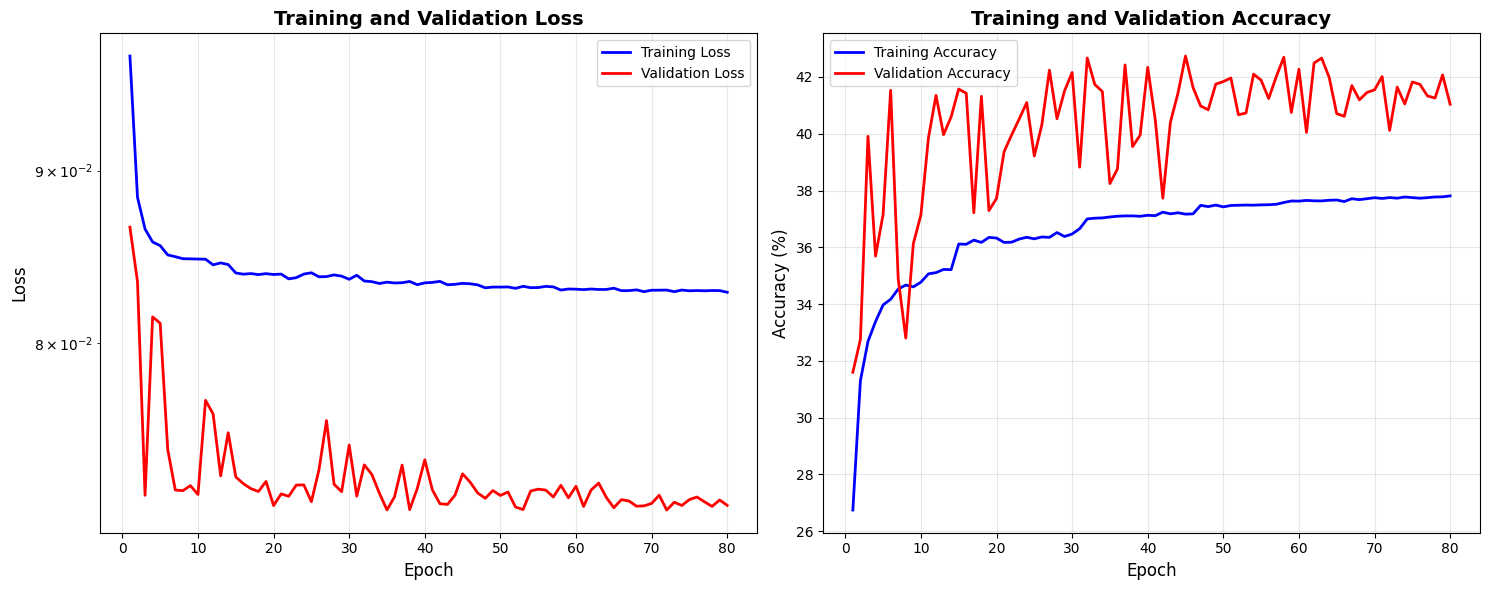

Training curves saved to training_curves.png

FINAL VALIDATION EVALUATION

WEATHER FORECASTING EVALUATION SUMMARY

T2M:
----------------------------------------
  RMSE:              0.6805
  MAE:               0.4029
  MAPE:              0.13%
  Bias:              -0.0099
  Correlation:       0.9556
  R² Score:          0.9120
  Anomaly Corr:      0.9556
  Skill Score:       0.5148
  Threshold Metrics:
    hit_rate_freezing: 0.0000
    hit_rate_hot: 0.7299


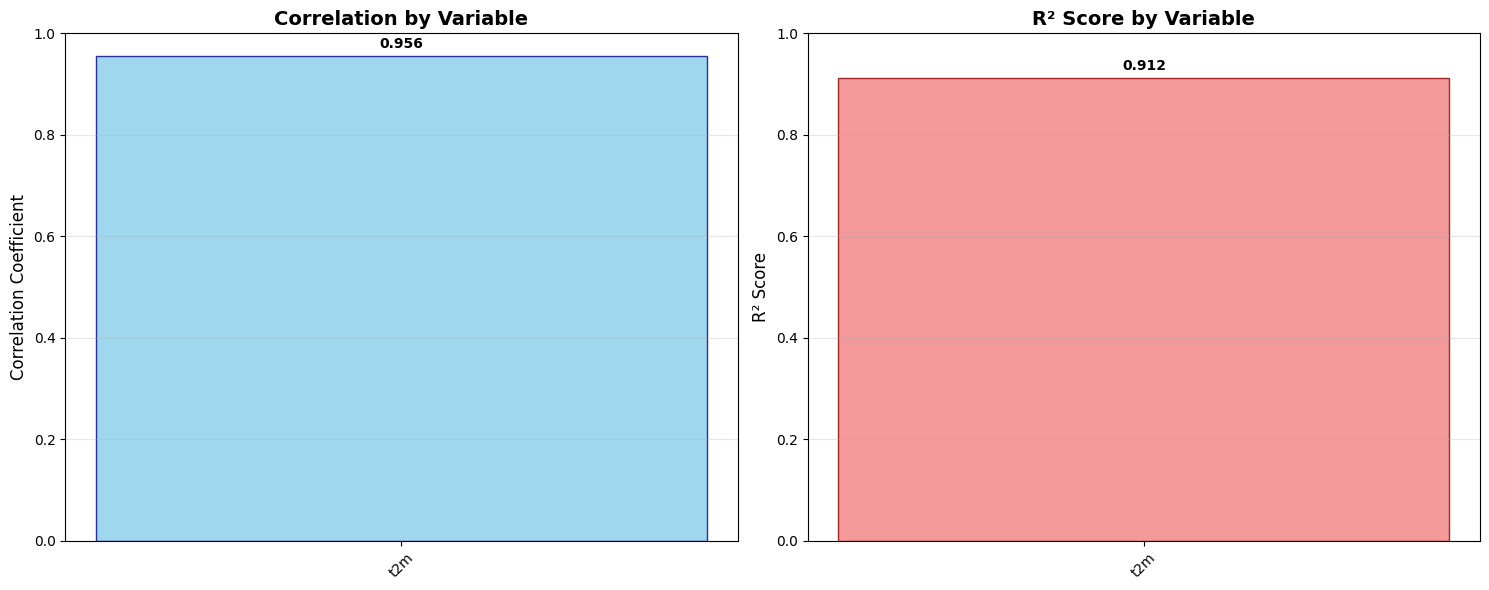

Variable accuracy plot saved to final_variable_accuracy.png


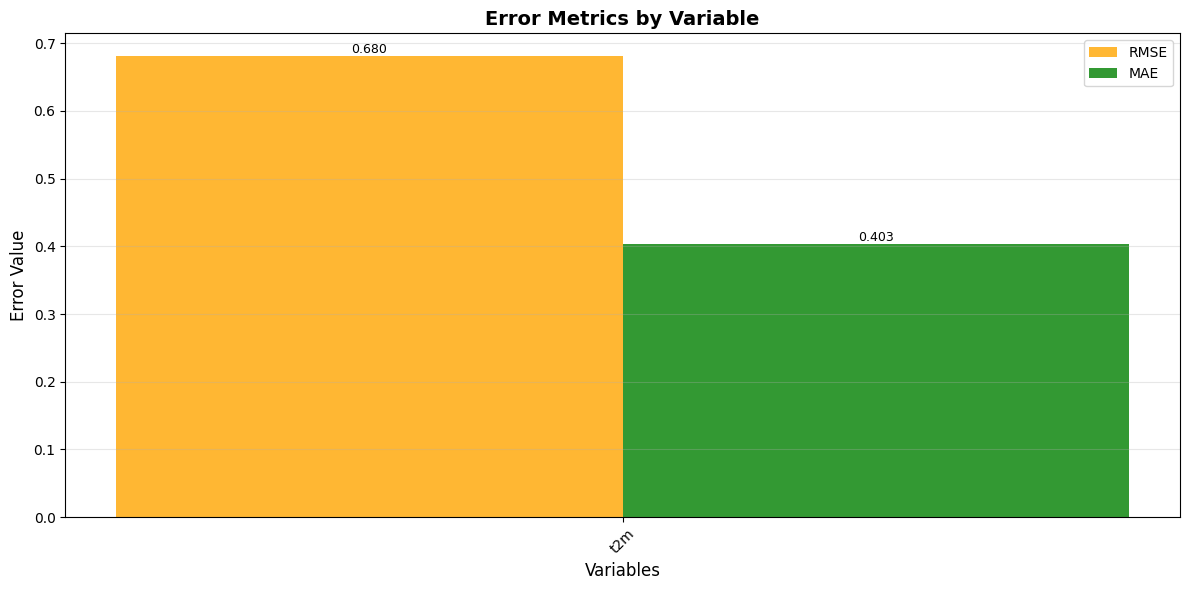

Error distribution plot saved to final_error_distribution.png

TEST SET EVALUATION
Test Loss: 0.080975
Test Accuracy: 37.83%

WEATHER FORECASTING EVALUATION SUMMARY

T2M:
----------------------------------------
  RMSE:              0.7237
  MAE:               0.4326
  MAPE:              0.14%
  Bias:              -0.0830
  Correlation:       0.9565
  R² Score:          0.9125
  Anomaly Corr:      0.9559
  Skill Score:       0.4658
  Threshold Metrics:
    hit_rate_freezing: 0.0000
    hit_rate_hot: 0.8039


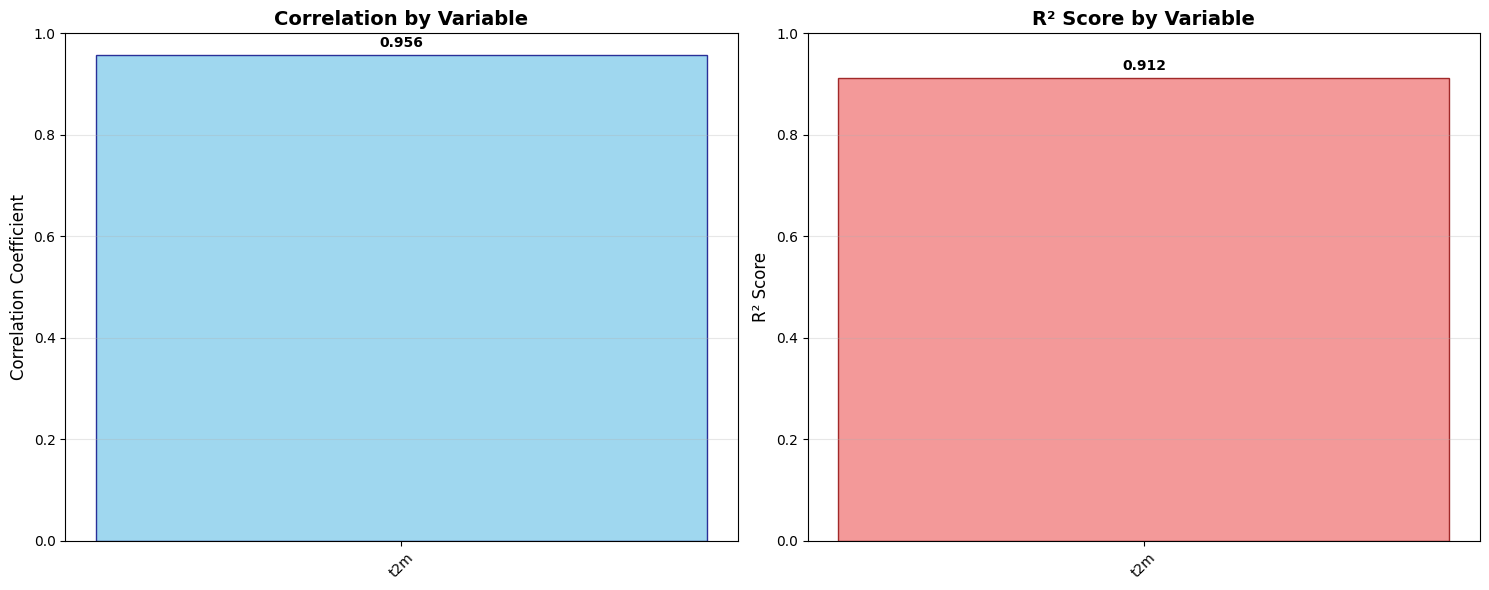

Variable accuracy plot saved to test_variable_accuracy.png


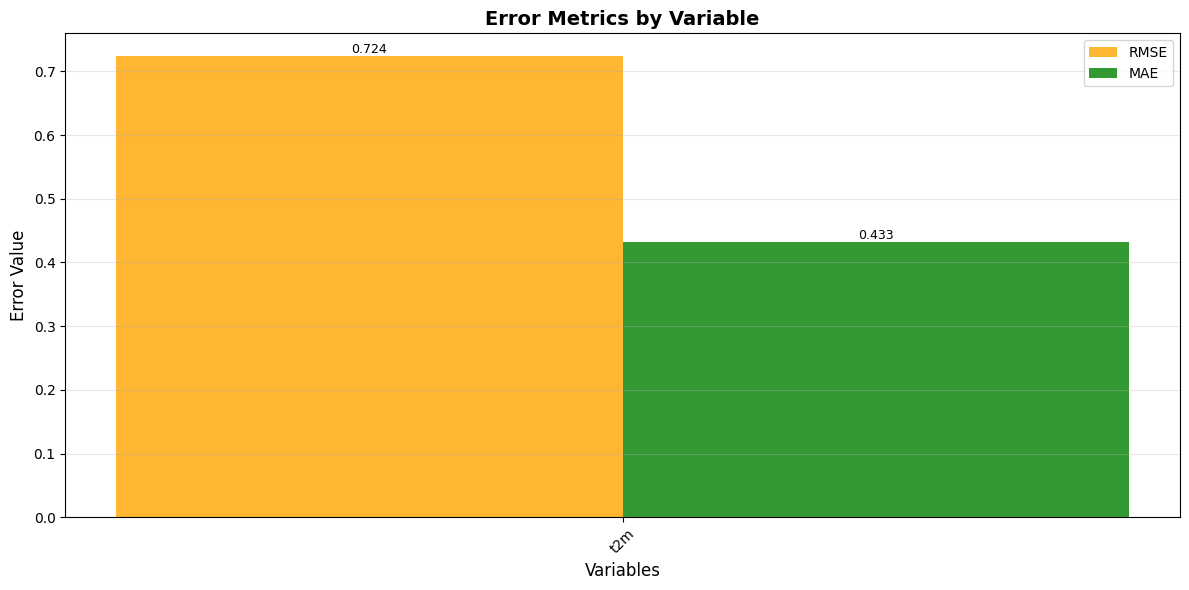

Error distribution plot saved to test_error_distribution.png

Training complete!
Comprehensive results saved to 'comprehensive_weather_metrics.json'
Training history saved to 'training_history.json'

FINAL SUMMARY
Final Training Loss: 0.082817
Final Training Accuracy: 37.81%
Final Validation Loss: 0.071598
Final Validation Accuracy: 41.04%
Test Loss: 0.080975
Test Accuracy: 37.83%

Generated files:
- training_curves.png
- final_variable_accuracy.png
- final_error_distribution.png
- test_variable_accuracy.png
- test_error_distribution.png
- comprehensive_weather_metrics.json
- training_history.json


In [11]:
if __name__ == '__main__':
    main()

In [ ]:
8